In [85]:
%matplotlib inline

import arcpy
import os, shutil
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from sklearn.metrics import r2_score
from scipy import stats


# workingDir = "Z:\Auxiliary\Project_Folders\CS_Sandbox\\NCALM\\bulking\\v2"
# arcpy.env.workspace=workingDir
arcpy.env.overwriteOutput = 1


In [86]:
# Set up functions

# Remove outlier function
def rmout(data, nstd):
    s = np.std(data)
    outInd = (data<data.mean()+nstd*data.std()) & (data>data.mean()-nstd*data.std())
    return s, outInd

##### BEFORE CONTINUING....
# Did you run Zonal Statistics as Table and use Joins to get the new data in?
### If not, see next block and make sure to collect DEM statistics as attributes in the debris flow polygons shapefile
- min, max elevation
- total upslope contributing area at toe of debris flow (da_at_toe)
- area of debris flow polygon (m2)
- total erosion (m3)
- total deposition (m3)

In [87]:
## Get total debris flow statistics

# Bring in polygon data
df_poly_data = arcpy.da.TableToNumPyArray('Full_DF_Vector\df_polys_trunk', ["df_id", "MIN", "MAX", "da_at_toe", "area_m2", "eros", "dep"])
df = pd.DataFrame(df_poly_data)
df.rename(columns={'MIN':'el_min'}, inplace=True)
df.rename(columns={'MAX':'el_max'}, inplace=True)

# Bring in line data for lengths
df_line_data = arcpy.da.TableToNumPyArray('Full_DF_Vector\df_lines', ['init_id', 'length_m'])

# Calculate/collate data for each df
dfl = pd.DataFrame(df_line_data)
dfl["df_id"] = dfl.init_id.str[:3]
dfl.loc[dfl['init_id'].str.endswith('T')]

dfj = pd.DataFrame()
dfj['num_izs'] = dfl.groupby(['df_id']).count().init_id
dfj['trunk_le'] = 0
dfj["trunk_le"] = dfl.groupby('df_id').length_m.max().values
dfj["total_le"] = dfl.groupby('df_id').length_m.sum().values

df = df.join(dfj, on='df_id')
df["mass_bal"] = df.eros + df.dep
df["growthFac_tot"] = -1*df.eros / df.total_le
df["growthFac_tru"] = -1*df.eros / df.trunk_le
df["hl_tot"] = (df.el_max - df.el_min) / df.total_le
df["hl_tru"] = (df.el_max - df.el_min) / df.trunk_le


print(df.head())

# Pickle the data
df.to_pickle(os.path.join("Z:\\Auxiliary\\Project_Folders\\CS_Sandbox\\NCALM\\bulking\\v2\\pkl", "bulkingv2.pkl"))

  df_id      el_min      el_max  ...  growthFac_tru    hl_tot    hl_tru
0   G28  316.635925  577.833069  ...       3.955744  0.273098  0.273098
1   G30  418.236359  698.797424  ...      12.690920  0.353859  0.353859
2   G03  453.847687  604.707642  ...      37.121302  0.399747  0.399747
3   G06  390.107239  539.656006  ...       2.955296  0.460153  0.460153
4   G16  322.283264  465.467529  ...       3.063708  0.318484  0.318484

[5 rows x 15 columns]


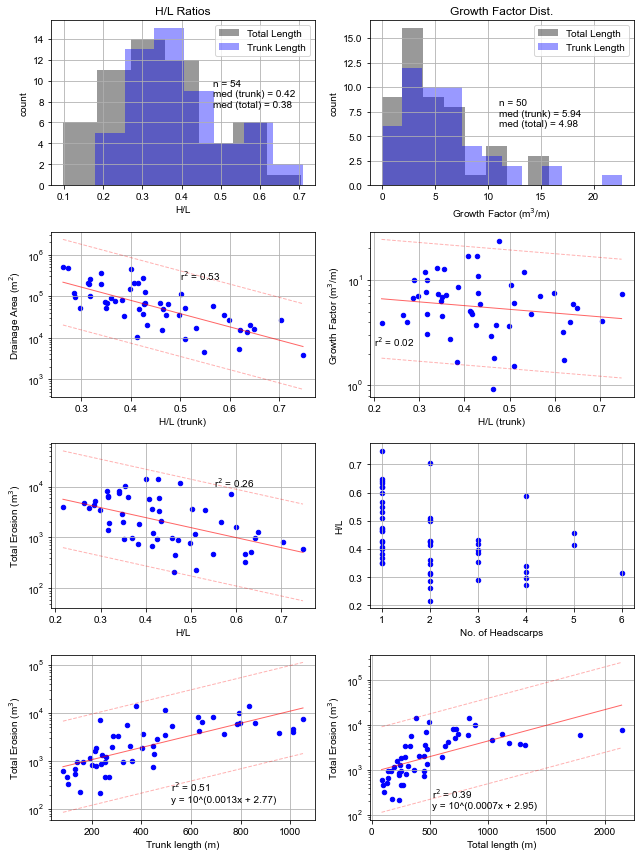

In [22]:
### Plot 1 - HL vs. X

paperWidth = 9
paperHeight = 12
mpl.rcParams['figure.figsize'] = [paperWidth, paperHeight]

fig, ([ax1, ax2], [ax3, ax4], [ax5, ax6], [ax7, ax8]) = plt.subplots(4, 2)


# HL histogram - total length
hl_tot_h, hl_tot_bins = np.histogram(df.hl_tot, bins='fd', density=0)
hl_tru_h, hl_tru_bins = np.histogram(df.hl_tru, bins='fd', density=0)
ax1.bar(hl_tot_bins[:-1], hl_tot_h, color='k', width=np.mean(np.diff(hl_tot_bins)), alpha = 0.4, label='Total Length')
ax1.bar(hl_tru_bins[:-1], hl_tru_h, color='b', width=np.mean(np.diff(hl_tru_bins)), alpha = 0.4, label='Trunk Length')
ax1.grid(1)
ax1.set_xlabel('H/L')
ax1.set_ylabel('count')
ax1.text(0.48, .5*np.max(hl_tru_h), 'n = {0}\nmed (trunk) = {1}\nmed (total) = {2}'.format(len(df.hl_tru), round(np.median(df.hl_tru), 2), round(np.median(df.hl_tot), 2)))
ax1.set_title('H/L Ratios')
ax1.legend()


# GF Histogram
s, outInd = rmout(df.growthFac_tot, 2)
gf_tot = np.abs(df.growthFac_tot[outInd])

s, outInd = rmout(df.growthFac_tru, 2)
gf_tru = np.abs(df.growthFac_tru[outInd])

gf_tot_h, gf_tot_bins = np.histogram(gf_tot, bins='fd', density=0)
gf_tru_h, gf_tru_bins = np.histogram(gf_tru, bins='fd', density=0)

ax2.bar(gf_tot_bins[:-1], gf_tot_h, color='k', width=np.mean(np.diff(gf_tot_bins)), alpha = 0.4, label='Total Length')
ax2.bar(gf_tru_bins[:-1], gf_tru_h, color='b', width=np.mean(np.diff(gf_tru_bins)), alpha = 0.4, label='Trunk Length')
ax2.grid(1)
ax2.set_xlabel('Growth Factor (m$^3$/m)')
ax2.set_ylabel('count')
ax2.text(11, .5*np.max(gf_tru_h), 'n = {0}\nmed (trunk) = {1}\nmed (total) = {2}'.format(len(gf_tru), round(np.median(gf_tru), 2), round(np.median(gf_tot), 2)))
ax2.set_title('Growth Factor Dist.')
ax2.legend()


# HL vs. DA at Toe
s, outInd = rmout(df.da_at_toe, 2)
da = df.da_at_toe[outInd]
hlx = df.hl_tru[outInd]

ax3.scatter(hlx, da, color='b', s=20)
ax3.grid(1)
ax3.set_xlabel('H/L (trunk)')
ax3.set_ylabel('Drainage Area (m$^2$)')
m, b = np.polyfit(hlx, np.log10(da), 1)
yp = m*np.sort(hlx) + b

ax3.plot(np.sort(hlx), 10**yp, 'r', alpha=0.6)
ax3.plot(np.sort(hlx), 10**(yp+(2*np.std(np.log10(da)))), 'r--', alpha=0.3)
ax3.plot(np.sort(hlx), 10**(yp-(2*np.std(np.log10(da)))), 'r--', alpha=0.3)
r2 = r2_score(np.log10(da), m*hlx + b)
ax3.text(0.5, .5*np.max(da), 'r$^2$ = {0}'.format(round(r2, 2)))
ax3.set_yscale('log')

# HL vs. Growth Factor
s, outInd = rmout(df.growthFac_tru, 2)
gf = df.growthFac_tru[outInd]
hlx = df.hl_tru[outInd]

ax4.scatter(hlx, gf, color='b', s=20)
ax4.grid(1)
ax4.set_xlabel('H/L (trunk)')
ax4.set_ylabel('Growth Factor (m$^3$/m)')
m, b = np.polyfit(hlx, np.log10(gf), 1)
yp = m*np.sort(hlx) + b

ax4.plot(np.sort(hlx), 10**yp, 'r', alpha=0.6)
ax4.plot(np.sort(hlx), 10**(yp+(2*np.std(np.log10(gf)))), 'r--', alpha=0.3)
ax4.plot(np.sort(hlx), 10**(yp-(2*np.std(np.log10(gf)))), 'r--', alpha=0.3)
r2 = r2_score(np.log10(gf), m*hlx + b)
ax4.text(0.2, .1*np.max(gf), 'r$^2$ = {0}'.format(round(r2, 2)))
ax4.set_yscale('log')

# HL vs. total erosion
s, outInd = rmout(df.eros, 2)
eros = np.abs(df.eros[outInd])
hlx = df.hl_tru[outInd]
ax5.scatter(hlx, eros, color='b', s=20)
ax5.grid(1)
ax5.set_xlabel('H/L')
ax5.set_ylabel('Total Erosion (m$^3$)')
m, b = np.polyfit(hlx, np.log10(eros), 1)
yp = m*np.sort(hlx) + b
ax5.plot(np.sort(hlx), 10**yp, 'r', alpha=0.6)
ax5.plot(np.sort(hlx), 10**(yp+(2*np.std(np.log10(eros)))), 'r--', alpha=0.3)
ax5.plot(np.sort(hlx), 10**(yp-(2*np.std(np.log10(eros)))), 'r--', alpha=0.3)
r2 = r2_score(np.log10(eros), m*hlx + b)
ax5.text(0.55, .7*np.max(eros), 'r$^2$ = {0}'.format(round(r2, 2)))
ax5.set_yscale('log')


# HL vs. num_izs
s, outInd = rmout(df.num_izs, 2)
niz = df.num_izs[outInd]
hlx = df.hl_tru[outInd]
ax6.scatter(niz, hlx, color='b', s=20)
ax6.grid(1)
ax6.set_ylabel('H/L')
ax6.set_xlabel('No. of Headscarps')
#m, b = np.polyfit(hlx, np.log10(niz), 1)
#yp = m*np.sort(hlx) + b
#ax6.plot(np.sort(hlx), 10**yp, 'r', alpha=0.6)
#ax6.plot(np.sort(hlx), 10**(yp+(2*np.std(np.log10(niz)))), 'r--', alpha=0.3)
#ax6.plot(np.sort(hlx), 10**(yp-(2*np.std(np.log10(niz)))), 'r--', alpha=0.3)
#r2 = r2_score(np.log10(niz), m*hlx + b)
#ax6.text(0.55, .7*np.max(niz), 'r$^2$ = {0}'.format(round(r2, 2)))
#ax6.set_yscale('log')

# Trunk length vs. total erosion - is it linear?
s, outInd = rmout(df.eros, 2)
eros = np.abs(df.eros[outInd])
lx = df.trunk_le[outInd]
ax7.scatter(lx, eros, color='b', s=20)
ax7.grid(1)
ax7.set_xlabel('Trunk length (m)')
ax7.set_ylabel('Total Erosion (m$^3$)')
m, b = np.polyfit(lx, np.log10(eros), 1)
yp = m*np.sort(lx) + b
ax7.plot(np.sort(lx), 10**yp, 'r', alpha=0.6)
ax7.plot(np.sort(lx), 10**(yp+(2*np.std(np.log10(eros)))), 'r--', alpha=0.3)
ax7.plot(np.sort(lx), 10**(yp-(2*np.std(np.log10(eros)))), 'r--', alpha=0.3)
r2 = r2_score(np.log10(eros), m*lx + b)
ax7.text(520, .01*np.max(eros), 'r$^2$ = {0}\ny = 10^({1}x + {2})'.format(round(r2, 2), round(m, 4), round(b, 2)))
ax7.set_yscale('log')

# Total length vs. total erosion - is it linear?
s, outInd = rmout(df.eros, 2)
eros = np.abs(df.eros[outInd])
lx = df.total_le[outInd]
ax8.scatter(lx, eros, color='b', s=20)
ax8.grid(1)
ax8.set_xlabel('Total length (m)')
ax8.set_ylabel('Total Erosion (m$^3$)')
m, b = np.polyfit(lx, np.log10(eros), 1)
yp = m*np.sort(lx) + b
ax8.plot(np.sort(lx), 10**yp, 'r', alpha=0.6)
ax8.plot(np.sort(lx), 10**(yp+(2*np.std(np.log10(eros)))), 'r--', alpha=0.3)
ax8.plot(np.sort(lx), 10**(yp-(2*np.std(np.log10(eros)))), 'r--', alpha=0.3)
r2 = r2_score(np.log10(eros), m*lx + b)
ax8.text(520, .01*np.max(eros), 'r$^2$ = {0}\ny = 10^({1}x + {2})'.format(round(r2, 2), round(m, 4), round(b, 2)))
ax8.set_yscale('log')




plt.tight_layout()
fig.savefig('Z:\\Auxiliary\\Project_Folders\\CS_Sandbox\\NCALM\\graphics\\scatterplots\\trunk_plots_LOD20cm.jpg', dpi=1000)
plt.show()
plt.close()


In [32]:
dastd = np.std(df.da_at_toe)
da = df[(df.da_at_toe<df.da_at_toe.mean()+2*df.da_at_toe.std()) & (df.da_at_toe>df.da_at_toe.mean()-2*df.da_at_toe.std())].da_at_toe
#np.log10(da.max())
print('mean: {0}'.format(np.log10(df.da_at_toe.mean())))
print('mean + 2 std: {0}'.format(np.log10(df.da_at_toe.mean()+2*df.da_at_toe.std())))
print('max still in data: {0}'.format(np.log10(da.max())))

mean: 5.747907929096313
mean + 2 std: 6.78971904407841
max still in data: 6.510570778921783
